### Plot features

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_response_vs_inputs(csv_path):
    df = pd.read_csv(csv_path)

    response_var = "y"
    input_vars = [f"x_{i:02d}" for i in range(1, 96)]
    c_vars = [f"C_{i:02d}" for i in range(1, 6)]
    
    existing_input_vars = [col for col in input_vars if col in df.columns]
    existing_c_vars = [col for col in c_vars if col in df.columns]
    
    for var in existing_input_vars:
        df_filtered = df[[response_var, var]].dropna()
        plt.figure(figsize=(6, 4))
        plt.scatter(df_filtered[var], df_filtered[response_var], alpha=0.5)
        plt.xlabel(var)
        plt.ylabel(response_var)
        plt.title(f"{response_var} vs {var}")
        plt.grid(True)
        plt.show()

    for var in existing_c_vars:
        df_filtered = df[[response_var, var]].dropna()
        plt.figure(figsize=(6, 4))
        plt.scatter(df_filtered[var], df_filtered[response_var], alpha=0.5)
        plt.xlabel(var)
        plt.ylabel(response_var)
        plt.title(f"{response_var} vs {var}")
        plt.grid(True)
        plt.show()

plot_response_vs_inputs("case1Data.csv")


c:\Users\Bbjar\anaconda3\envs\adv_image\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Bbjar\anaconda3\envs\adv_image\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


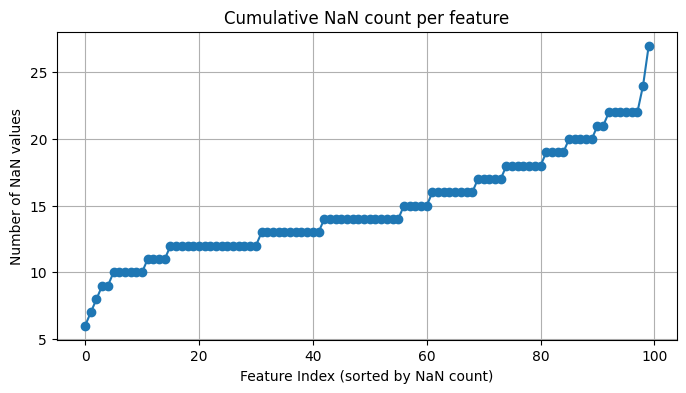

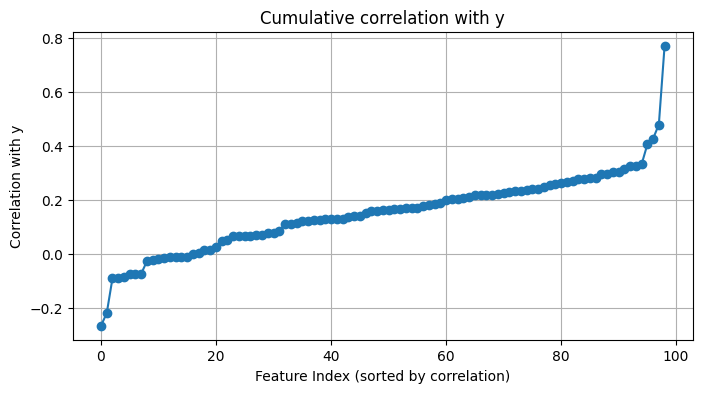

{'Mean': np.float64(211.5212379629106),
 'Std': np.float64(72.47649920974135),
 'Median': np.float64(215.25794722553087),
 'Max': np.float64(375.823073005362),
 'Min': np.float64(39.70221769951189),
 'Number of Datapoints': np.int64(100)}

In [4]:
import numpy as np

def analyze_dataset(csv_path):
    df = pd.read_csv(csv_path)

    response_var = "y"
    input_vars = [f"x_{i:02d}" for i in range(1, 96)]
    c_vars = [f"C_{i:02d}" for i in range(1, 6)]
    
    existing_vars = [col for col in input_vars + c_vars if col in df.columns]

    y_stats = {
        "Mean": df[response_var].mean(),
        "Std": df[response_var].std(),
        "Median": df[response_var].median(),
        "Max": df[response_var].max(),
        "Min": df[response_var].min(),
        "Number of Datapoints": df[response_var].count()
    }

    nan_counts = df[existing_vars].isna().sum().sort_values()
    correlation_scores = df[existing_vars].corrwith(df[response_var]).dropna().sort_values()

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(nan_counts)), nan_counts.values, marker="o")
    plt.xlabel("Feature Index (sorted by NaN count)")
    plt.ylabel("Number of NaN values")
    plt.title("Cumulative NaN count per feature")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(len(correlation_scores)), correlation_scores.values, marker="o")
    plt.xlabel("Feature Index (sorted by correlation)")
    plt.ylabel("Correlation with y")
    plt.title("Cumulative correlation with y")
    plt.grid(True)
    plt.show()

    return y_stats

# Example usage:
analyze_dataset("case1Data.csv")


### Describe model, model selection, validation etc.

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

##### 1 Split into train, test, val
##### 2 Fill in missing NaN values as MEDIAN value of feature

In [5]:
#Define functions
def split_dataframe(df, train_size=60, val_size=20, test_size=20, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(len(df))
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_df = df.iloc[train_indices].reset_index(drop=True)
    val_df = df.iloc[val_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, val_df, test_df

df = pd.read_csv("case1Data.csv")
df_filled = df.fillna(df.median())
xTrain, xVal, xTest = split_dataframe(df_filled)

##### Load X_no_label, the 1000 datapoints without a label

In [6]:
X_no_label = pd.read_csv("case1Data_Xnew.csv")
X_no_label = X_no_label.fillna(X_no_label.median())

### PCA on X_no_label

In [20]:
### Hyperparams

n_components = 30

In [21]:
def compute_pca_transformer(X_no_label, n_components=2):    
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(X_no_label)
    normalization_constants = {"mean": scaler.mean_, "std": scaler.scale_}
    
    pca = PCA(n_components=n_components)
    pca.fit(normalized_data)
    
    return pca, normalization_constants

pca_transformer, normalization_constants = compute_pca_transformer(X_no_label, n_components=n_components)

##### plot PCA 

Total variance explained by the included PCs: 0.8189


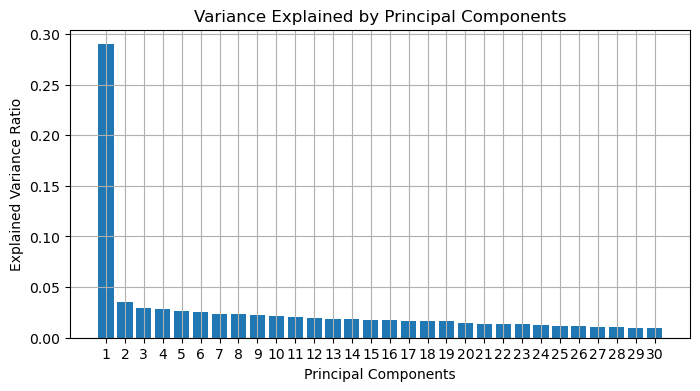

In [23]:
def plot_pca_variance(pca):
    explained_variance = pca.explained_variance_ratio_
    total_variance = np.sum(explained_variance)

    print(f"Total variance explained by the included PCs: {total_variance:.4f}")

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, 
            tick_label=[f"{i}" for i in range(1, len(explained_variance) + 1)])
    plt.xlabel("Principal Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Variance Explained by Principal Components")
    plt.grid(True)
    plt.show()

    
plot_pca_variance(pca_transformer)

##### How to Handle missing data. How to handle categorical variables

### Estimate predictive performance of RSS